In [119]:
import numpy as np
import pandas as pd
import os

os.environ["PROJ_LIB"] = "/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/share/proj/"
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.basemap import Basemap

import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn import model_selection
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_auc_score
import boto3
import warnings
import pickle

%matplotlib inline

# Reading Data

In [2]:
df_event = pd.read_csv("/Users/chiraggodawat/Desktop/Upgrad/Capstone/Part_2/event_data/000000_0",sep=",",header=None)
df_event.columns =['Device_Id','Gender','Age','Age Group', 'Event_ID', 'Event_Time_Stamp', 'Long','Lat']
df_event.head()

/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Device_Id,Gender,Age,Age Group,Event_ID,Event_Time_Stamp,Long,Lat
0,-7548291590301750000,M,33,M32+,414,2016-05-03 00:05:31.0,116.79,33.98
1,-7548291590301750000,M,33,M32+,2604805,2016-05-04 03:01:32.0,116.79,33.98
2,-7548291590301750000,M,33,M32+,2588911,2016-05-03 16:14:14.0,116.79,33.98
3,-7548291590301750000,M,33,M32+,2586055,2016-05-02 14:36:04.0,116.79,33.98
4,-7548291590301750000,M,33,M32+,2560938,2016-05-02 18:01:00.0,116.79,33.98


In [3]:
df_non_event = pd.read_csv("/Users/chiraggodawat/Desktop/Upgrad/Capstone/Part_2/non_event_data/000000_0",sep=",",header=None)
df_non_event.columns = ['Device_Id','Gender','Age','Age Group', 'Phone Brand', 'Device Model']
df_non_event.head()

,Device_Id,Gender,Age,Age Group,Phone Brand,Device Model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


In [4]:
#As app_data is in parts, reading them in parts and concating in one single dataframe
df_app = pd.DataFrame()

df_list = []
for i in range(0,8):
    df = pd.read_csv("/Users/chiraggodawat/Desktop/Upgrad/Capstone/Part_2/app_data/00000"+ str(i) +"_0",sep=",",header=None)
    df_list.append(df)

df_app = pd.concat(df_list, axis=0, ignore_index=True)
df_app.columns = ['Event_Id','App_Id','Is_Installed','Is_Active','Label_Id', 'Label_Category']
df_app.head()

,Event_Id,App_Id,Is_Installed,Is_Active,Label_Id,Label_Category
0,2,5927333115845830913,1,1,549,Property Industry 1.0
1,2,5927333115845830913,1,1,172,IM
2,2,5927333115845830913,1,1,548,Industry tag
3,2,5927333115845830913,1,1,704,Property Industry 2.0
4,2,5927333115845830913,1,1,710,Relatives 1


In [5]:
print("df_app shape",df_app.shape)
print("df_event shape", df_event.shape)
print("df_non_event shape", df_non_event.shape)

df_app shape (104617724, 6)
df_event shape (1266933, 8)
df_non_event shape (74646, 6)


# Cleaning Data

   ### Geospatial Data Cleaning 

In [6]:
df_event = df_event[-((df_event['Lat']==0) & (df_event['Long']==0))]

In [7]:
df_event.shape

(920392, 8)

### Other Cleaning

In [8]:
#Converting the timestamp column
df_event['Event_Time_Stamp'] = pd.to_datetime(df_event['Event_Time_Stamp'],errors ='coerce')
df_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920392 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Device_Id         920392 non-null  int64         
 1   Gender            920392 non-null  object        
 2   Age               920392 non-null  int64         
 3   Age Group         920392 non-null  object        
 4   Event_ID          920392 non-null  object        
 5   Event_Time_Stamp  869057 non-null  datetime64[ns]
 6   Long              920392 non-null  object        
 7   Lat               920392 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 63.2+ MB


Null Value Checks 


In [9]:
#Get Percentage of null values
df_event.isna().sum()*100/df_event.count()

Device_Id           0.000000
Gender              0.000000
Age                 0.000000
Age Group           0.000000
Event_ID            0.000000
Event_Time_Stamp    5.906977
Long                0.000000
Lat                 0.000000
dtype: float64

In [10]:
df_app.isna().sum()*100/df_app.count()

Event_Id          0.0
App_Id            0.0
Is_Installed      0.0
Is_Active         0.0
Label_Id          0.0
Label_Category    0.0
dtype: float64

In [11]:
df_non_event.isna().sum()*100/df_non_event.count()

Device_Id       0.0
Gender          0.0
Age             0.0
Age Group       0.0
Phone Brand     0.0
Device Model    0.0
dtype: float64

In [12]:
# So we have null values only in df_event and as it is around 6per only, 
# So we can remove the those rows as it wont affect our data much

df_event.dropna(inplace=True)

In [13]:
df_event.isna().sum()*100/df_event.count()

Device_Id           0.0
Gender              0.0
Age                 0.0
Age Group           0.0
Event_ID            0.0
Event_Time_Stamp    0.0
Long                0.0
Lat                 0.0
dtype: float64

Lets check each of the necessary columns in each dataframe, whether they contain proper values or nor (For eg. Gender colum should have only M, F as values)

In [14]:
#df_event

df_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869057 entries, 0 to 1251632
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Device_Id         869057 non-null  int64         
 1   Gender            869057 non-null  object        
 2   Age               869057 non-null  int64         
 3   Age Group         869057 non-null  object        
 4   Event_ID          869057 non-null  object        
 5   Event_Time_Stamp  869057 non-null  datetime64[ns]
 6   Long              869057 non-null  object        
 7   Lat               869057 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 59.7+ MB


In [15]:
df_event.describe()

,Device_Id,Age
count,8.690570e+05,869057.000000
mean,-9.784744e+16,33.623961
std,5.305375e+18,9.757887
min,-9.222957e+18,14.000000
25%,-4.752132e+18,27.000000
50%,-2.169639e+17,31.000000
75%,4.575946e+18,39.000000
max,9.220915e+18,88.000000


In [16]:
df_event['Gender'].value_counts()

M    630201
F    238856
Name: Gender, dtype: int64

In [17]:
df_event['Age Group'].value_counts()

M32+      283687
M25-32    255970
F32+      113954
M0-24      90544
F25-32     88151
F0-24      36751
Name: Age Group, dtype: int64

In [18]:
df_event['Lat'].describe()

count     869057.0
unique      3316.0
top            1.0
freq       27612.0
Name: Lat, dtype: float64

In [19]:
df_event['Long'].describe()

#This dataset looks good. Moving to df_app

count     869057.0
unique      3566.0
top            1.0
freq       27604.0
Name: Long, dtype: float64

In [20]:
#Df_app

df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104617724 entries, 0 to 104617723
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Event_Id        int64 
 1   App_Id          int64 
 2   Is_Installed    int64 
 3   Is_Active       int64 
 4   Label_Id        int64 
 5   Label_Category  object
dtypes: int64(5), object(1)
memory usage: 4.7+ GB


In [21]:
df_app.describe()

,Event_Id,App_Id,Is_Installed,Is_Active,Label_Id
count,1.046177e+08,1.046177e+08,104617724.0,1.046177e+08,1.046177e+08
mean,1.624971e+06,1.336797e+18,1.0,3.411841e-01,5.947480e+02
std,9.377997e+05,5.201954e+18,0.0,4.741071e-01,2.388198e+02
min,2.000000e+00,-9.221157e+18,1.0,0.000000e+00,2.000000e+00
25%,8.134850e+05,-2.741012e+18,1.0,0.000000e+00,4.050000e+02
50%,1.626707e+06,1.886579e+18,1.0,0.000000e+00,7.040000e+02
75%,2.440243e+06,5.927333e+18,1.0,1.000000e+00,7.570000e+02
max,3.252948e+06,9.222488e+18,1.0,1.000000e+00,1.021000e+03


In [22]:
df_app['Label_Category'].value_counts()[:5]

#Here we have category as unknown which is fourth largest in count. But maybe it might help us in model building.
#So Lets keep it here for now. Will see if anything needs to be done for this in later stage
#Moving to df_non_event

Industry tag             12117200
Property Industry 2.0     8411347
Property Industry 1.0     6840511
unknown                   6518956
Custom label              4115987
Name: Label_Category, dtype: int64

In [23]:
df_non_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74646 entries, 0 to 74645
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Device_Id     74646 non-null  int64 
 1   Gender        74646 non-null  object
 2   Age           74646 non-null  int64 
 3   Age Group     74646 non-null  object
 4   Phone Brand   74646 non-null  object
 5   Device Model  74646 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


In [24]:
df_non_event.describe()

,Device_Id,Age
count,7.464600e+04,74646.000000
mean,-6.788546e+14,31.410163
std,5.327149e+18,9.868791
min,-9.223067e+18,1.000000
25%,-4.617358e+18,25.000000
50%,-1.837725e+16,29.000000
75%,4.637026e+18,36.000000
max,9.222849e+18,96.000000


In [25]:
# Min Age =1 ??!!  Seems wierd. 
# Lets check for number of rows with age <8 (After 8, a human can use the apps with a pattern and understanding) 
df_non_event[df_non_event.Age<8].count()

Device_Id       5
Gender          5
Age             5
Age Group       5
Phone Brand     5
Device Model    5
dtype: int64

In [26]:
#So we have 5 rows with Age < 8. Lets remove them as it doesn't seem that for Age<8 the data would make any sense

df_non_event = df_non_event[-(df_non_event.Age<8)]
df_non_event[df_non_event.Age<8].count()

Device_Id       0
Gender          0
Age             0
Age Group       0
Phone Brand     0
Device Model    0
dtype: int64

In [27]:
df_non_event['Age Group'].value_counts()

M25-32    19837
M32+      16284
M0-24     11779
F25-32    10716
F32+       9755
F0-24      6270
Name: Age Group, dtype: int64

In [28]:
df_non_event['Gender'].value_counts()

M    47900
F    26741
Name: Gender, dtype: int64

In [29]:
df_non_event['Phone Brand'].value_counts()

Xiaomi     17300
samsung    13668
Huawei     12960
OPPO        5783
vivo        5637
           ...  
fs             1
pner           1
MIL            1
Ctyon          1
mole           1
Name: Phone Brand, Length: 97, dtype: int64

In [30]:
df_non_event['Device Model'].value_counts()

xnote                 3013
MI 3                  2299
MI 2S                 2136
Galaxy Note 3         2065
MI 4                  1910
                      ... 
MediaPad 10 Link+?       1
a1234C                   1
S90-e                    1
F8909                    1
A238t                    1
Name: Device Model, Length: 1438, dtype: int64

Now our data looks good. Lets move ahead

# Basic EDA and Visualization and Feature Engineering Ideas

Plot appropriate graphs representing the distribution of age and gender in the data set [univariate].

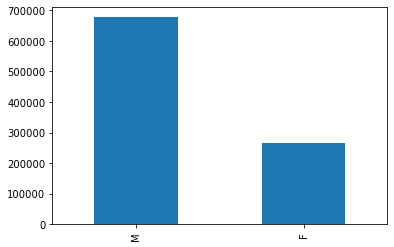

In [31]:
# Considering gender from both event and non event data

gender_distribution = df_non_event.Gender.value_counts() + df_event.Gender.value_counts() 
gender_distribution.plot(kind='bar')

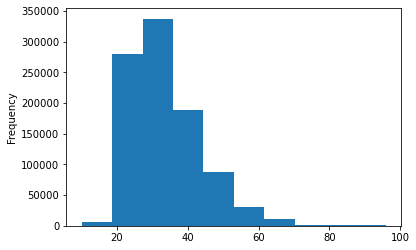

In [32]:
age_dist = pd.concat([df_event['Age'],df_non_event['Age']],axis=0)
age_dist.plot(kind='hist')

Boxplot analysis for gender and age [bivariate].

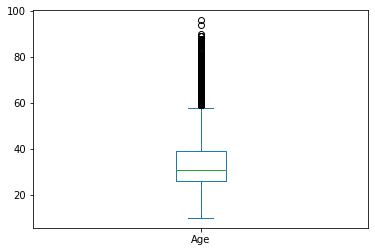

In [33]:
gender_age_dist = pd.concat([df_event[['Age','Gender']],df_non_event[['Age','Gender']]],axis=0)
gender_age_dist.plot(kind='box')

Plot the percentage of the device_ids with and without event data. 

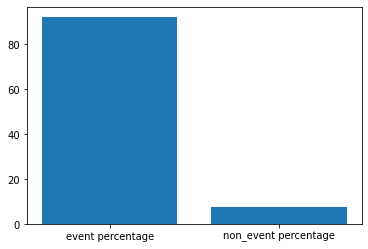

In [34]:
#With Event Data

total_count =df_event.shape[0] + df_non_event.shape[0]

dict_percentage = {'event percentage': float(df_event.shape[0]*100/total_count), 'non_event percentage': float(df_non_event.shape[0]*100/total_count)}

plt.bar(range(len(dict_percentage)), list(dict_percentage.values()), align='center')
plt.xticks(range(len(dict_percentage)), list(dict_percentage.keys()))

plt.show()


Plot a graph representing the distribution of events over different days of a week. 

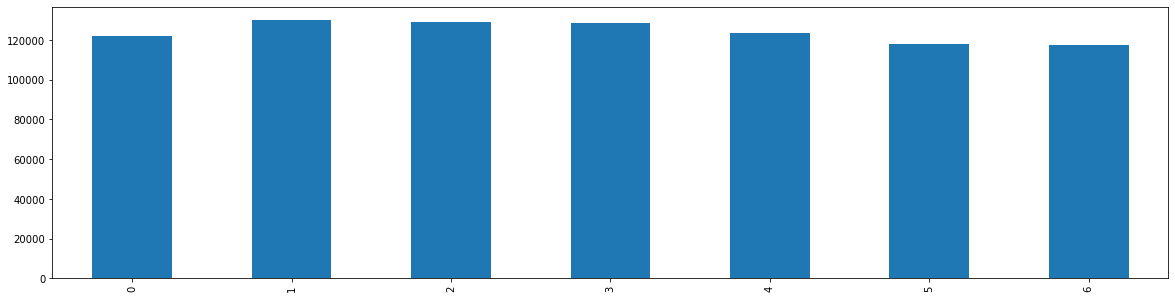

In [35]:
week_event_data = df_event['Event_Time_Stamp'].dt.dayofweek
week_event_data.value_counts().sort_index().plot(kind='bar',figsize=(20,5))

In [36]:
#There is some variations we see over here. (On Graph its not much, but the scale pf y axis is high)
# So lets create a column in df_event for this

df_event['Day Of Week'] = df_event['Event_Time_Stamp'].dt.dayofweek


Plot a graph representing the distribution of events per hour [for one-week data].

In [37]:
#Identifying week of year, to select one particular week
df_event['Event_Time_Stamp'].dt.weekofyear.value_counts()

/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


18    751215
17    117842
Name: Event_Time_Stamp, dtype: int64

/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


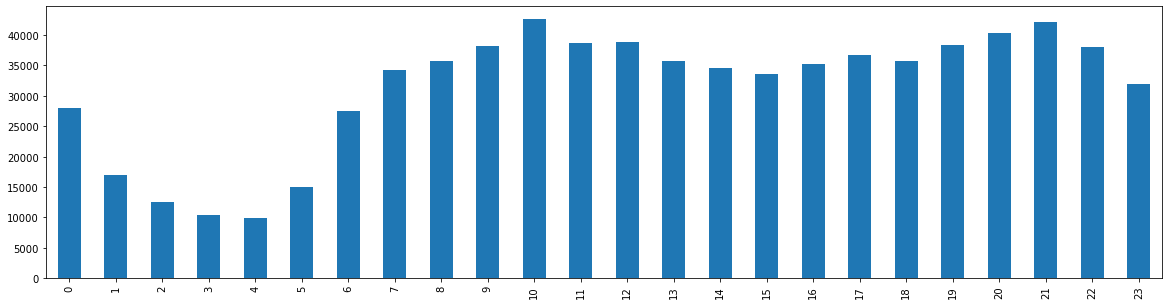

In [38]:
hour_event_data = df_event[df_event['Event_Time_Stamp'].dt.weekofyear==18]['Event_Time_Stamp'].dt.hour
hour_event_data.value_counts().sort_index().plot(kind='bar',figsize=(20,5))

In [39]:
#Clearly there is a pattern in activity based on hour.
#So lets add this as a coulmn in our data set

df_event['Hour'] = df_event['Event_Time_Stamp'].dt.hour   #converting all time stamps to hours (Not only for one week)
df_event.head()

,Device_Id,Gender,Age,Age Group,Event_ID,Event_Time_Stamp,Long,Lat,Day Of Week,Hour
0,-7548291590301750000,M,33,M32+,414,2016-05-03 00:05:31,116.79,33.98,1,0
1,-7548291590301750000,M,33,M32+,2604805,2016-05-04 03:01:32,116.79,33.98,2,3
2,-7548291590301750000,M,33,M32+,2588911,2016-05-03 16:14:14,116.79,33.98,1,16
3,-7548291590301750000,M,33,M32+,2586055,2016-05-02 14:36:04,116.79,33.98,0,14
4,-7548291590301750000,M,33,M32+,2560938,2016-05-02 18:01:00,116.79,33.98,0,18


The difference in the distribution of events per hour for Male and Female consumers. [Show the difference using an appropriate chart for one-week data.]

/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


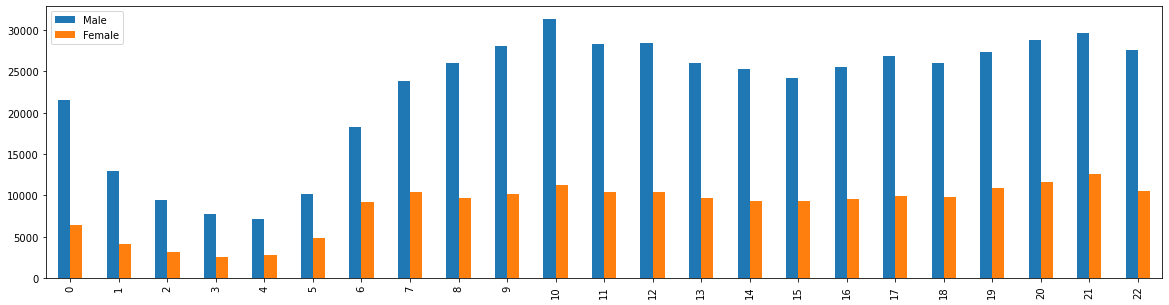

In [40]:
hour_range = range(0,23)

#Creating dummy df of 1 week (week no 18)
df_event_dummy = df_event[df_event['Event_Time_Stamp'].dt.weekofyear==18]


hour_male_data = df_event_dummy[df_event_dummy.Gender=='M']['Event_Time_Stamp'].dt.hour.value_counts()

hour_female_data = df_event_dummy[df_event_dummy.Gender=='F']['Event_Time_Stamp'].dt.hour.value_counts()

combined_df = pd.DataFrame({'Male':hour_male_data, 'Female':hour_female_data}, index=hour_range)

combined_df.plot(kind='bar',figsize=(20,5))


Is there any difference in the distribution of Events for different Age Groups over different days of the week? [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

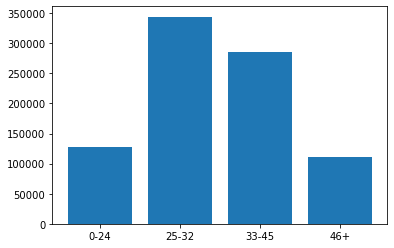

In [41]:
dummy_dict = {'0-24': df_event[(df_event['Age']<=24)].shape[0],
             '25-32': df_event[(df_event['Age']>24)& (df_event['Age']<=32)].shape[0],
             '33-45': df_event[(df_event['Age']>32)& (df_event['Age']<=45)].shape[0],
             '46+':df_event[(df_event['Age']>45)].shape[0]}
plt.bar(dummy_dict.keys(), dummy_dict.values())
plt.show()

Stacked bar chart for the top 10 mobile brands across male and female consumers.

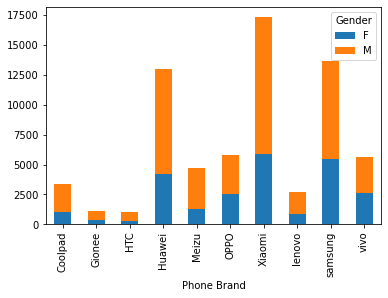

In [42]:
stacked_data = df_non_event['Phone Brand'].value_counts()[:10] # Top 10 brands


stacked_df = df_non_event.loc[(df_non_event['Phone Brand'].isin(list(stacked_data.index)))][['Gender','Phone Brand']].groupby(['Phone Brand','Gender'])['Gender'].count()

stacked_df = stacked_df.unstack(level=1)

stacked_df.plot(kind='bar', stacked=True)

In [43]:
# As there is a clear pattern in this. So Lets create a flag which tells wether phone brand is in top 10 or not

def create_top_phone_brand_flag(row):
    if row['Phone Brand'] in list(stacked_data.index):
        return 1
    else:
        return 0

In [44]:
df_non_event['Is_Popular_Phone_Brand'] = df_non_event.apply(create_top_phone_brand_flag,axis=1)
df_non_event.head()

,Device_Id,Gender,Age,Age Group,Phone Brand,Device Model,Is_Popular_Phone_Brand
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,1
1,6943568600617760000,M,37,M32+,Xiaomi,xnote,1
2,5441349705980020000,M,40,M32+,OPPO,R7s,1
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4,1
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4,1


Prepare a chart representing the ten frequently used applications and their respective male and female percentage.

In [45]:
df_app_filtered = df_app[df_app['Is_Active']==1] #Only taking data in which app is being used


df_event_filtered = df_event[['Gender','Event_ID']] #creating to get gender and make a merge to get gender precentage

df_event_filtered.columns = ['Gender','Event_Id']

df_filtered_data = df_app_filtered.merge(df_event_filtered, on='Event_Id',how='left')

df_filtered = df_filtered_data[-(df_filtered_data.isnull())]  #Removing Null value Rows after Merge

Text(0, 0.5, 'Percentage')

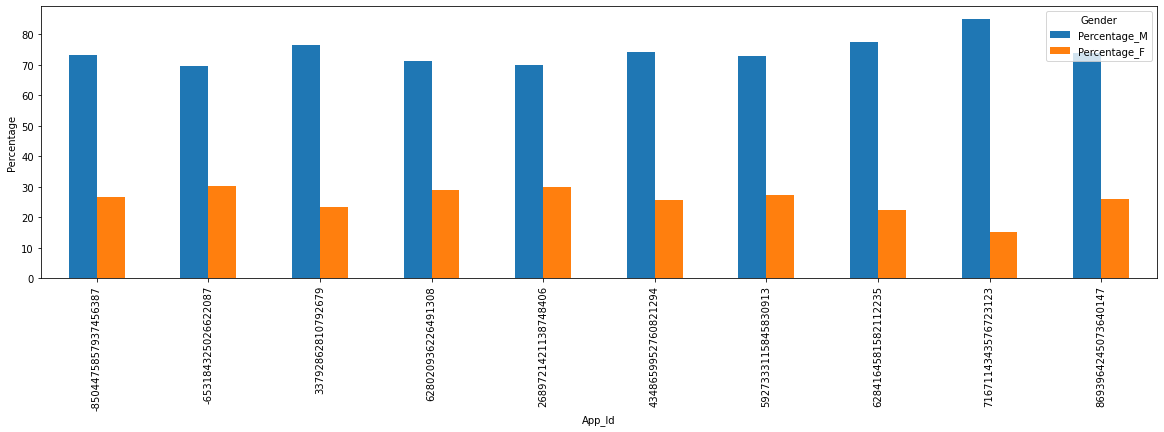

In [46]:
top_app_ids = df_filtered['App_Id'].value_counts()[0:10]  # Top 10 App ID

stacked_df = df_filtered.loc[(df_filtered['App_Id'].isin(list(top_app_ids.index)))][['Gender','App_Id']].groupby(['App_Id','Gender'])['Gender'].count()

stacked_df = stacked_df.unstack(level=1)

stacked_df['Total'] = stacked_df['M'] + stacked_df['F']

stacked_df['Percentage_M'] = stacked_df['M']*100/stacked_df['Total'] 
stacked_df['Percentage_F'] = stacked_df['F']*100/stacked_df['Total'] 

stacked_df.drop(['M','F','Total'], axis='columns',inplace=True)

bar_plot_percentage = stacked_df.plot(kind='bar',figsize=(20,5))

bar_plot_percentage.set_ylabel('Percentage')

List the top 10 mobile phone brands bought by customers by age groups. [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

In [47]:
list_age_group = ['0-24','25-32','33-45','46+']

def create_age_group(value):
    if value['Age']<=24:
        return list_age_group[0]
    elif (value['Age']>24 and value['Age']<=32):
        return list_age_group[1]
    elif (value['Age']>32 and value['Age']<=45):
        return list_age_group[2]
    elif (value['Age']>45):
        return list_age_group[3]

In [48]:
temp_df_non_event = df_non_event[['Age','Phone Brand']]

temp_df_non_event['Age Group'] = temp_df_non_event.apply(create_age_group, axis=1)

temp_df_non_event.drop(['Age'],inplace=True,axis='columns')

temp_df = temp_df_non_event.groupby(['Age Group','Phone Brand'])['Phone Brand'].count()


/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
for i in list_age_group:
    print("Age Group: ", i )
    print(temp_df[(i,)].sort_values(ascending=False)[:10]) # List of Top 10 brands for each group seperately
    print("\n")

Age Group:  0-24
Phone Brand
Xiaomi     4229
Huawei     2443
samsung    2358
vivo       1975
OPPO       1856
Meizu      1680
Coolpad     808
lenovo      612
Gionee      328
HTC         236
Name: Phone Brand, dtype: int64


Age Group:  25-32
Phone Brand
Xiaomi     7537
samsung    5555
Huawei     5100
OPPO       2367
vivo       2317
Meizu      2052
Coolpad    1208
lenovo     1005
HTC         436
Gionee      400
Name: Phone Brand, dtype: int64


Age Group:  33-45
Phone Brand
samsung    4175
Xiaomi     4000
Huawei     3964
OPPO       1183
vivo       1013
Coolpad     942
lenovo      738
Meizu       687
Gionee      278
HTC         251
Name: Phone Brand, dtype: int64


Age Group:  46+
Phone Brand
samsung    1580
Xiaomi     1534
Huawei     1453
Coolpad     381
OPPO        377
lenovo      336
vivo        332
Meizu       276
Gionee      117
ZTE         115
Name: Phone Brand, dtype: int64




In [50]:
# As we have already created hours and weekof day columns in event_data, 
#lets remove the time stamp column as its not important now

df_event.drop(['Event_Time_Stamp'],axis='columns', inplace=True)

Lets visualize all our datasets once now

In [51]:
df_event.head()

,Device_Id,Gender,Age,Age Group,Event_ID,Long,Lat,Day Of Week,Hour
0,-7548291590301750000,M,33,M32+,414,116.79,33.98,1,0
1,-7548291590301750000,M,33,M32+,2604805,116.79,33.98,2,3
2,-7548291590301750000,M,33,M32+,2588911,116.79,33.98,1,16
3,-7548291590301750000,M,33,M32+,2586055,116.79,33.98,0,14
4,-7548291590301750000,M,33,M32+,2560938,116.79,33.98,0,18


In [52]:
df_non_event.head()

,Device_Id,Gender,Age,Age Group,Phone Brand,Device Model,Is_Popular_Phone_Brand
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,1
1,6943568600617760000,M,37,M32+,Xiaomi,xnote,1
2,5441349705980020000,M,40,M32+,OPPO,R7s,1
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4,1
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4,1


In [53]:
df_app.head()

,Event_Id,App_Id,Is_Installed,Is_Active,Label_Id,Label_Category
0,2,5927333115845830913,1,1,549,Property Industry 1.0
1,2,5927333115845830913,1,1,172,IM
2,2,5927333115845830913,1,1,548,Industry tag
3,2,5927333115845830913,1,1,704,Property Industry 2.0
4,2,5927333115845830913,1,1,710,Relatives 1


# Advanced Visualization and Clustering

### Geospatial Visualisation

Plot the visualisation plot for a sample of 1 lakh data points.

In [54]:
#df_event = df_event.sample(frac=1).reset_index(drop=True)  ## Shuffling the data

df_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869057 entries, 0 to 1251632
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Device_Id    869057 non-null  int64 
 1   Gender       869057 non-null  object
 2   Age          869057 non-null  int64 
 3   Age Group    869057 non-null  object
 4   Event_ID     869057 non-null  object
 5   Long         869057 non-null  object
 6   Lat          869057 non-null  object
 7   Day Of Week  869057 non-null  int64 
 8   Hour         869057 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 66.3+ MB


In [55]:
#Converting lat and longitude to int

df_event['Lat'] = pd.to_numeric(df_event['Lat'])
df_event['Long'] = pd.to_numeric(df_event['Long'])

df_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869057 entries, 0 to 1251632
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Device_Id    869057 non-null  int64  
 1   Gender       869057 non-null  object 
 2   Age          869057 non-null  int64  
 3   Age Group    869057 non-null  object 
 4   Event_ID     869057 non-null  object 
 5   Long         869057 non-null  float64
 6   Lat          869057 non-null  float64
 7   Day Of Week  869057 non-null  int64  
 8   Hour         869057 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 66.3+ MB


/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


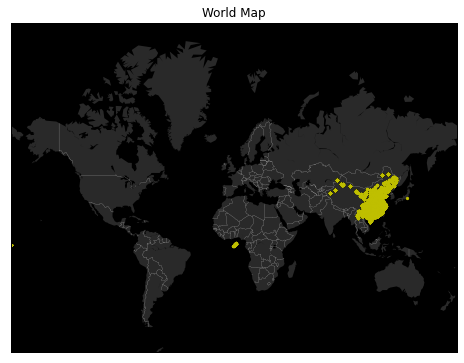

In [56]:
vis_data = df_event[:100000] #Selecting 1 lakh data points

fig = plt.figure(figsize=(8, 8))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=-65,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=85, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=-180,#longitude of lower left hand corner of the desired map domain
             urcrnrlon=180, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#292929',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(vis_data["Long"].tolist(), vis_data["Lat"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="y", zorder=2)

plt.title("World Map")
plt.show()

Compare the event visualisation plots based on the users' gender information. [This can be done on the sample of 1 lakh data points.]

/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


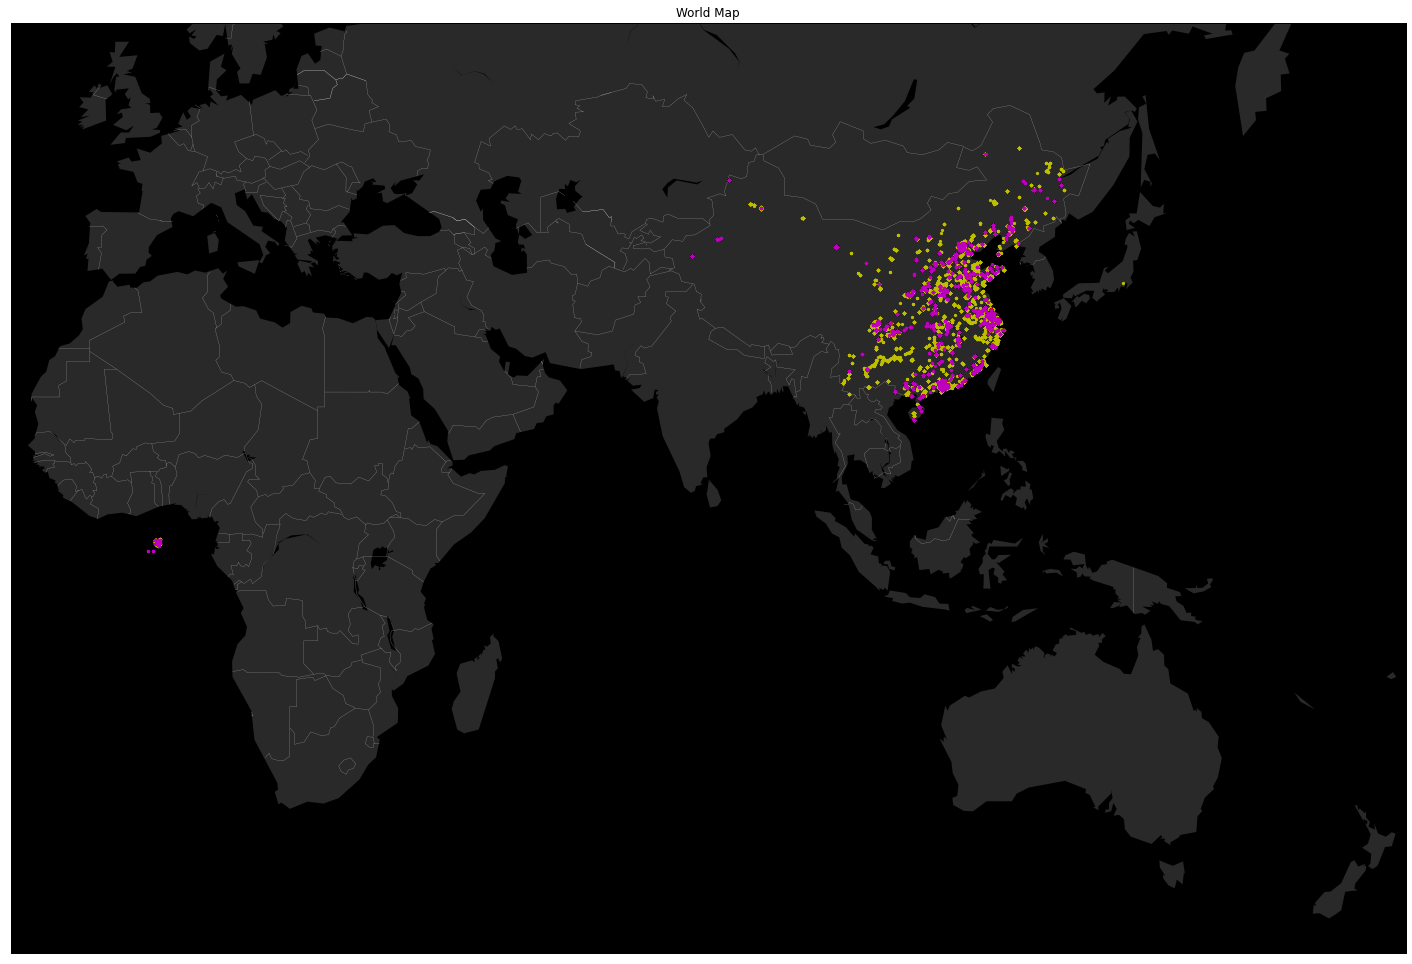

In [57]:
#As seen above most of the data is present in eastern side.

#Hence increasing fig_size and adjusting diagram so that gender information is visible

fig = plt.figure(figsize=(25, 50))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=-50,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=60, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=-20,#longitude of lower left hand corner of the desired map domain
             urcrnrlon=180, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#292929',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy_male = m(vis_data[vis_data['Gender']=="M"]["Long"].tolist(), vis_data[vis_data['Gender']=="M"]["Lat"].tolist())
m.scatter(mxy_male[0], mxy_male[1], s=5, c="y", zorder=2)


mxy_female = m(vis_data[vis_data['Gender']=="F"]["Long"].tolist(), vis_data[vis_data['Gender']=="F"]["Lat"].tolist())
m.scatter(mxy_female[0], mxy_female[1], s=5, c="m", zorder=2)


plt.title("World Map")
plt.show()

Compare the event visualisation plots based on the following age groups:

0–24 

25–32

32+

In [58]:
list_age_group = ['0-24','25-32','32+']

def create_age_group_1(value):
    if value['Age']<=24:
        return list_age_group[0]
    elif (value['Age']>24 and value['Age']<=32):
        return list_age_group[1]
    elif (value['Age']>32):
        return list_age_group[2]


In [59]:
vis_data['Only Age Group'] = vis_data.apply(create_age_group_1, axis=1)
vis_data.head()

/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Device_Id,Gender,Age,Age Group,Event_ID,Long,Lat,Day Of Week,Hour,Only Age Group
0,-7548291590301750000,M,33,M32+,414,116.79,33.98,1,0,32+
1,-7548291590301750000,M,33,M32+,2604805,116.79,33.98,2,3,32+
2,-7548291590301750000,M,33,M32+,2588911,116.79,33.98,1,16,32+
3,-7548291590301750000,M,33,M32+,2586055,116.79,33.98,0,14,32+
4,-7548291590301750000,M,33,M32+,2560938,116.79,33.98,0,18,32+


/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/chiraggodawat/opt/anaconda3/envs/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


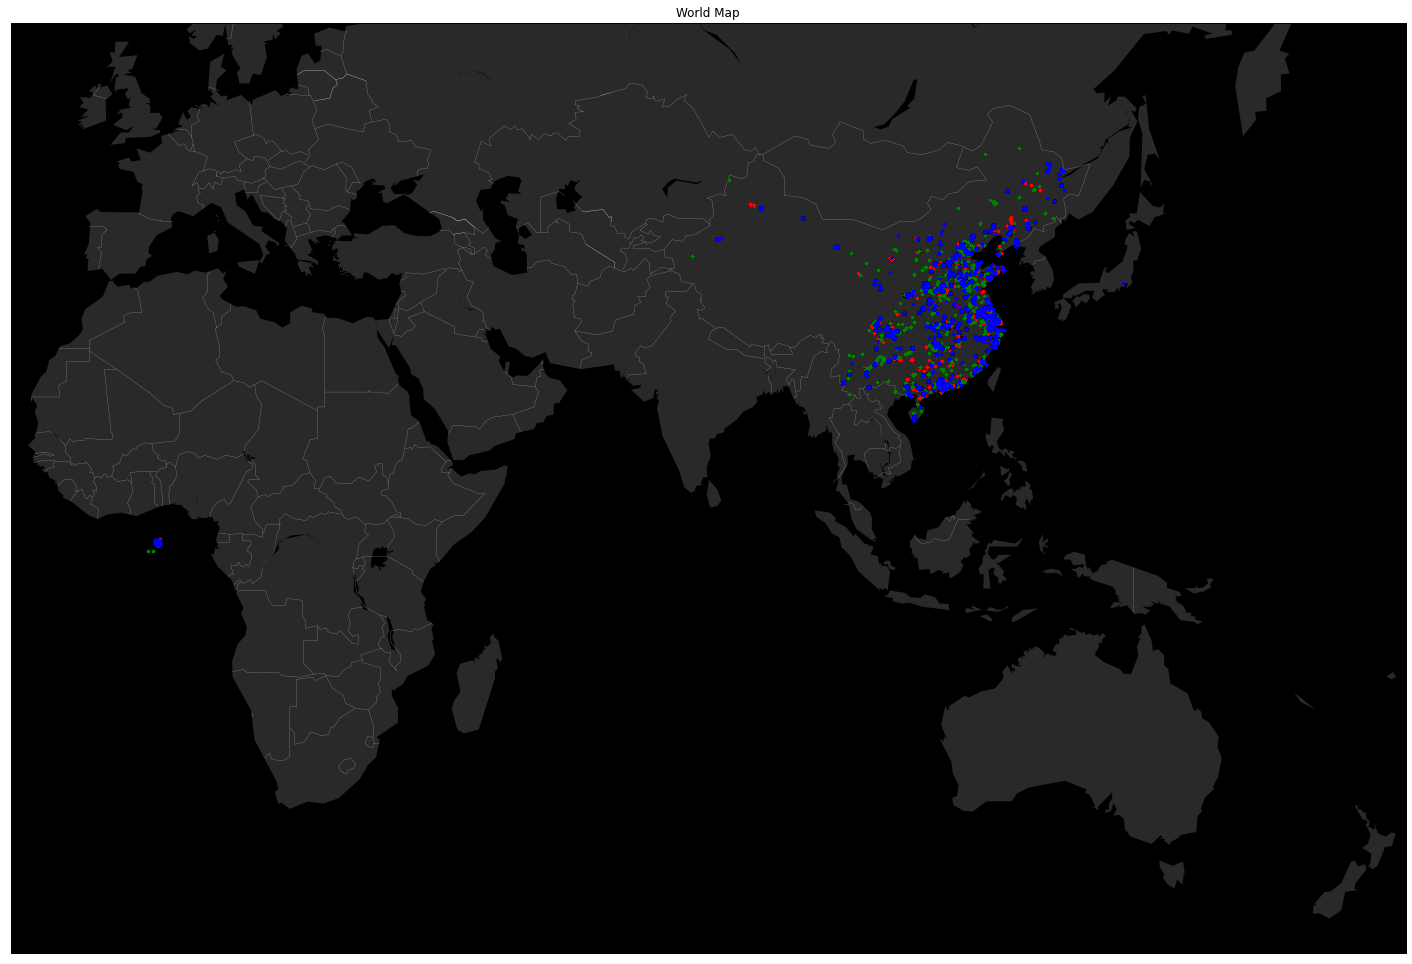

In [60]:
fig = plt.figure(figsize=(25, 50))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=-50,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=60, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=-20,#longitude of lower left hand corner of the desired map domain
             urcrnrlon=180, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#292929',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy_age_group_1 = m(vis_data[vis_data['Only Age Group']=="0-24"]["Long"].tolist(), vis_data[vis_data['Only Age Group']=="0-24"]["Lat"].tolist())
m.scatter(mxy_age_group_1[0], mxy_age_group_1[1], s=5, c="r", zorder=2)


mxy_age_group_2 = m(vis_data[vis_data['Only Age Group']=="25-32"]["Long"].tolist(), vis_data[vis_data['Only Age Group']=="25-32"]["Lat"].tolist())
m.scatter(mxy_age_group_2[0], mxy_age_group_2[1], s=5, c="g", zorder=2)

mxy_age_group_3 = m(vis_data[vis_data['Only Age Group']=="32+"]["Long"].tolist(), vis_data[vis_data['Only Age Group']=="32+"]["Lat"].tolist())
m.scatter(mxy_age_group_3[0], mxy_age_group_3[1], s=5, c="b", zorder=2)


plt.title("World Map")
plt.show()

### DBSCAN Clustering as a preprocessing technique

In [61]:
coords = df_event[['Lat','Long']].values
coords.shape

(869057, 2)

In [62]:
kms_per_radian = 6371.0088
epsilon = 1/kms_per_radian
db = DBSCAN(eps= epsilon, min_samples= 700, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))

In [63]:
print("No. Of Clusters: ",len(set(db.labels_)))

No. Of Clusters:  70


In [64]:
df_event['Cluster'] = db.labels_
df_event.head()

,Device_Id,Gender,Age,Age Group,Event_ID,Long,Lat,Day Of Week,Hour,Cluster
0,-7548291590301750000,M,33,M32+,414,116.79,33.98,1,0,-1
1,-7548291590301750000,M,33,M32+,2604805,116.79,33.98,2,3,-1
2,-7548291590301750000,M,33,M32+,2588911,116.79,33.98,1,16,-1
3,-7548291590301750000,M,33,M32+,2586055,116.79,33.98,0,14,-1
4,-7548291590301750000,M,33,M32+,2560938,116.79,33.98,0,18,-1


### Final Data Preparation and Train-Test Splitting

In [65]:
#Creating a join to create 2 data set, with event, and without event (No need of join in non_event as it is already complete)

#Creating Left join on event_data with App id, with Event_data being left 
df_event.rename(columns={'Event_ID':'Event_Id'},inplace=True)
df_with_event = df_event.merge(df_app, on='Event_Id',how='left')
df_with_event.head()

,Device_Id,Gender,Age,Age Group,Event_Id,Long,Lat,Day Of Week,Hour,Cluster,App_Id,Is_Installed,Is_Active,Label_Id,Label_Category
0,-7548291590301750000,M,33,M32+,414,116.79,33.98,1,0,-1,NaN,NaN,NaN,NaN,NaN
1,-7548291590301750000,M,33,M32+,2604805,116.79,33.98,2,3,-1,NaN,NaN,NaN,NaN,NaN
2,-7548291590301750000,M,33,M32+,2588911,116.79,33.98,1,16,-1,NaN,NaN,NaN,NaN,NaN
3,-7548291590301750000,M,33,M32+,2586055,116.79,33.98,0,14,-1,NaN,NaN,NaN,NaN,NaN
4,-7548291590301750000,M,33,M32+,2560938,116.79,33.98,0,18,-1,NaN,NaN,NaN,NaN,NaN


In [66]:
#Checking null value percentage after merge


df_with_event.isnull().sum()*100/df_with_event.count()

Device_Id         0.000000
Gender            0.000000
Age               0.000000
Age Group         0.000000
Event_Id          0.000000
Long              0.000000
Lat               0.000000
Day Of Week       0.000000
Hour              0.000000
Cluster           0.000000
App_Id            4.720524
Is_Installed      4.720524
Is_Active         4.720524
Label_Id          4.720524
Label_Category    4.720524
dtype: float64

So we have around 4.7% data for which we have the vent information but not the app information. Lets remove them

In [67]:
#Removing null values after merge

df_with_event.dropna(inplace=True)
df_with_event.isna().sum()

Device_Id         0
Gender            0
Age               0
Age Group         0
Event_Id          0
Long              0
Lat               0
Day Of Week       0
Hour              0
Cluster           0
App_Id            0
Is_Installed      0
Is_Active         0
Label_Id          0
Label_Category    0
dtype: int64

In [68]:
#Checking if App_Id is Categorical or not
df_with_event.App_Id.value_counts()

 4.348660e+18    716162
 8.693964e+18    394211
 5.927333e+18    310200
 6.280209e+17    275772
 3.379286e+16    252880
                  ...  
-2.097878e+18         1
-3.022873e+18         1
 5.909311e+18         1
 4.040747e+18         1
 5.353758e+18         1
Name: App_Id, Length: 9641, dtype: int64

In [69]:
# Checking if Label Id is categorical or not
df_with_event.Label_Id.value_counts()

548.0    1812199
704.0    1263773
549.0    1045000
713.0     627733
405.0     612682
          ...   
998.0          2
53.0           2
75.0           2
81.0           1
947.0          1
Name: Label_Id, Length: 471, dtype: int64

In [70]:
#count of device id might be useful 
#(no_of_events_for_particular_device_id
average_event_df = df_with_event.groupby('Device_Id')['Device_Id'].count()
average_event_df

Device_Id
-9222956879900150000    6814
-9221026417907250000     619
-9220061629197650000    3253
-9218769147970100000     273
-9212424538588390000     130
                        ... 
 9212688420052880000     103
 9215085115859650000    1726
 9216925254504440000    3133
 9219164468944550000    7835
 9220914901466450000     163
Name: Device_Id, Length: 10602, dtype: int64

In [71]:
def map_count_of_device_id(row):
    
    return average_event_df[row['Device_Id']]

In [72]:
df_with_event['Event Count For Device ID'] = df_with_event.apply(map_count_of_device_id,axis=1)
df_with_event.head()

,Device_Id,Gender,Age,Age Group,Event_Id,Long,Lat,Day Of Week,Hour,Cluster,App_Id,Is_Installed,Is_Active,Label_Id,Label_Category,Event Count For Device ID
294,4543988487649880000,M,53,M32+,2385752,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,721.0,Personal Effectiveness 1,773
295,4543988487649880000,M,53,M32+,2385752,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,303.0,unknown,773
296,4543988487649880000,M,53,M32+,2385752,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,302.0,unknown,773
297,4543988487649880000,M,53,M32+,2385752,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,548.0,Industry tag,773
298,4543988487649880000,M,53,M32+,2385752,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,704.0,Property Industry 2.0,773


In [73]:
# Remove the ID Columns as they wont help in training model
# Keeping App_Id and Label_id as they are categorical in nature, and removing Label_Category as Label_Id would be in sync with Label-Category 

df_with_event.drop(columns=['Event_Id','Label_Category'], axis=1, inplace=True)
df_with_event.reset_index(drop=True,inplace=True)
df_with_event.head()

,Device_Id,Gender,Age,Age Group,Long,Lat,Day Of Week,Hour,Cluster,App_Id,Is_Installed,Is_Active,Label_Id,Event Count For Device ID
0,4543988487649880000,M,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,721.0,773
1,4543988487649880000,M,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,303.0,773
2,4543988487649880000,M,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,302.0,773
3,4543988487649880000,M,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,548.0,773
4,4543988487649880000,M,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,704.0,773


In [74]:
def gender_to_categorical(row):
    if(row['Gender']=='M'):
        return 0
    else:
        return 1

In [75]:
df_with_event['Gender'] = df_with_event.apply(gender_to_categorical, axis=1)
df_with_event.head()

,Device_Id,Gender,Age,Age Group,Long,Lat,Day Of Week,Hour,Cluster,App_Id,Is_Installed,Is_Active,Label_Id,Event Count For Device ID
0,4543988487649880000,0,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,721.0,773
1,4543988487649880000,0,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,303.0,773
2,4543988487649880000,0,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,302.0,773
3,4543988487649880000,0,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,548.0,773
4,4543988487649880000,0,53,M32+,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,704.0,773


In [76]:
#Creating Age Group column as pure age and not gender age combined

dict_age_group_mapping = {0:'0-24',1:'25-32',2:'32+'}
def create_age_group_2(row):
    age = row['Age']
    
    if(age<=24):
        return 0
    elif (age>24 and age<=32):
        return 1
    else:
        return 2

In [77]:
df_with_event['Age Group'] = df_with_event.apply(create_age_group_2,axis=1)
df_with_event.head()

,Device_Id,Gender,Age,Age Group,Long,Lat,Day Of Week,Hour,Cluster,App_Id,Is_Installed,Is_Active,Label_Id,Event Count For Device ID
0,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,721.0,773
1,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,303.0,773
2,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,302.0,773
3,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,548.0,773
4,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,-5.720079e+18,1.0,1.0,704.0,773


In [78]:
#Creating a categorical variable from AppID as App ID values are too large

df_with_event.App_Id = pd.Categorical(df_with_event.App_Id )
df_with_event['App Id Categorical'] = df_with_event.App_Id.cat.codes
df_with_event.drop(['App_Id'],inplace=True,axis=1)
df_with_event.head()

,Device_Id,Gender,Age,Age Group,Long,Lat,Day Of Week,Hour,Cluster,Is_Installed,Is_Active,Label_Id,Event Count For Device ID,App Id Categorical
0,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,721.0,773,1634
1,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,303.0,773,1634
2,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,302.0,773,1634
3,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,548.0,773,1634
4,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,704.0,773,1634


In [79]:
#Same thing with Label ID
df_with_event.Label_Id = pd.Categorical(df_with_event.Label_Id )
df_with_event['Label Id Categorical'] = df_with_event.Label_Id.cat.codes
df_with_event.drop(['Label_Id'],inplace=True,axis=1)
df_with_event.head()

#Now this data looks good. lets check non_event data

,Device_Id,Gender,Age,Age Group,Long,Lat,Day Of Week,Hour,Cluster,Is_Installed,Is_Active,Event Count For Device ID,App Id Categorical,Label Id Categorical
0,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,274
1,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,227
2,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,226
3,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,236
4,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,257


In [80]:
#Non Event Data

df_non_event.head()

,Device_Id,Gender,Age,Age Group,Phone Brand,Device Model,Is_Popular_Phone_Brand
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,1
1,6943568600617760000,M,37,M32+,Xiaomi,xnote,1
2,5441349705980020000,M,40,M32+,OPPO,R7s,1
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4,1
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4,1


In [81]:
df_non_event['Gender'] = df_non_event.apply(gender_to_categorical, axis=1) #Categorising gender
df_non_event['Age Group'] = df_non_event.apply(create_age_group_2,axis=1) #Categorising Age Group

df_non_event['Phone Brand'] = pd.Categorical(df_non_event['Phone Brand'])
df_non_event['Phone Brand'] = df_non_event['Phone Brand'].cat.codes

df_non_event['Device Model']= pd.Categorical(df_non_event['Device Model'])
df_non_event['Device Model'] = df_non_event['Device Model'].cat.codes

df_non_event.head()


,Device_Id,Gender,Age,Age Group,Phone Brand,Device Model,Is_Popular_Phone_Brand
0,-7548291590301750000,0,33,2,11,1389,1
1,6943568600617760000,0,37,2,37,1322,1
2,5441349705980020000,0,40,2,24,838,1
3,-5393876656119450000,0,33,2,37,687,1
4,4543988487649880000,0,53,2,86,519,1


In [82]:
#Test Train Split
df_test_train_split = pd.read_csv("train_test_split.csv")
df_test_train_split.rename(columns={'device_id':'Device_Id'},inplace=True)
df_test_train_split = df_test_train_split[['Device_Id','train_test_flag']]
df_test_train_split

,Device_Id,train_test_flag
0,-7548291590301750000,train
1,6943568600617760000,train
2,5441349705980020000,train
3,-5393876656119450000,train
4,4543988487649880000,train
...,...,...
74640,-8270585312108800000,test
74641,9140950698473710000,test
74642,-5051737733034250000,test
74643,-6901678500015010000,test


In [83]:
#For event_data

df_event_train_test = df_with_event.merge(df_test_train_split,on='Device_Id', how='left')
df_event_train_test

,Device_Id,Gender,Age,Age Group,Long,Lat,Day Of Week,Hour,Cluster,Is_Installed,Is_Active,Event Count For Device ID,App Id Categorical,Label Id Categorical,train_test_flag
0,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,274,train
1,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,227,train
2,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,226,train
3,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,236,train
4,4543988487649880000,0,53,2,104.26,30.88,3,4,-1,1.0,1.0,773,1634,257,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15676667,-6245867196994660000,0,46,2,120.18,32.21,5,19,-1,1.0,1.0,1710,1111,308,test
15676668,-6245867196994660000,0,46,2,120.18,32.21,5,19,-1,1.0,1.0,1710,1111,304,test
15676669,-6245867196994660000,0,46,2,120.18,32.21,5,19,-1,1.0,1.0,1710,1111,293,test
15676670,-6245867196994660000,0,46,2,120.18,32.21,5,19,-1,1.0,1.0,1710,1111,292,test


In [84]:
#Sanity check after merge
df_event_train_test.isnull().sum()

Device_Id                    0
Gender                       0
Age                          0
Age Group                    0
Long                         0
Lat                          0
Day Of Week                  0
Hour                         0
Cluster                      0
Is_Installed                 0
Is_Active                    0
Event Count For Device ID    0
App Id Categorical           0
Label Id Categorical         0
train_test_flag              0
dtype: int64

In [85]:
#With non event data

df_non_event_train_test = df_non_event.merge(df_test_train_split,on='Device_Id', how='left')
df_non_event_train_test

,Device_Id,Gender,Age,Age Group,Phone Brand,Device Model,Is_Popular_Phone_Brand,train_test_flag
0,-7548291590301750000,0,33,2,11,1389,1,train
1,6943568600617760000,0,37,2,37,1322,1,train
2,5441349705980020000,0,40,2,24,838,1,train
3,-5393876656119450000,0,33,2,37,687,1,train
4,4543988487649880000,0,53,2,86,519,1,train
...,...,...,...,...,...,...,...,...
74636,-8270585312108800000,1,32,1,24,1020,1,test
74637,9140950698473710000,0,41,2,11,709,1,test
74638,-5051737733034250000,0,25,1,37,1317,1,test
74639,-6901678500015010000,1,20,0,88,1122,1,test


In [86]:
#Sanity check after merge
df_non_event_train_test.isnull().sum()

Device_Id                 0
Gender                    0
Age                       0
Age Group                 0
Phone Brand               0
Device Model              0
Is_Popular_Phone_Brand    0
train_test_flag           0
dtype: int64

# Model Building: Different Models

Using Classifier for age prediction as predicting a class makes it easier for prediction and improves accuracy. As compared to regression where we need to compare the exact age.

Eg. If the age predicted in regression is 32 (24-32 group) and actual is 33 (32+ group). So even a small error in age prediction of regression changes the entire age age group.

### Segmenting the data [Scenario 1 and Scenario 2] 

In [87]:
#Not considering Device ID as it is not a feature but a id unique to a device

x_train_1 = df_event_train_test[df_event_train_test['train_test_flag']=='train'][
    ['Long','Lat','Day Of Week','Hour','Cluster','Is_Installed','Is_Active','Event Count For Device ID',
     'App Id Categorical', 'Label Id Categorical']] #'Device_Id',


y_train_1_Age = df_event_train_test[df_event_train_test['train_test_flag']=='train']['Age Group']

y_train_1_Gender = df_event_train_test[df_event_train_test['train_test_flag']=='train']['Gender']

In [88]:
x_train_2 = df_non_event_train_test[df_non_event_train_test['train_test_flag']=='train'][
    ['Phone Brand','Device Model','Is_Popular_Phone_Brand']]  #'Device_Id',

y_train_2_Age = df_non_event_train_test[df_non_event_train_test['train_test_flag']=='train']['Age Group']

y_train_2_Gender = df_non_event_train_test[df_non_event_train_test['train_test_flag']=='train']['Gender']

In [89]:
x_test_1 = df_event_train_test[df_event_train_test['train_test_flag']=='test'][
    ['Long','Lat','Day Of Week','Hour','Cluster','Is_Installed','Is_Active','Event Count For Device ID',
     'App Id Categorical', 'Label Id Categorical']] #'Device_Id',


y_test_1_Age = df_event_train_test[df_event_train_test['train_test_flag']=='test']['Age Group']

y_test_1_Gender = df_event_train_test[df_event_train_test['train_test_flag']=='test']['Gender']

In [90]:
x_test_2 = df_non_event_train_test[df_non_event_train_test['train_test_flag']=='test'][
    ['Phone Brand','Device Model','Is_Popular_Phone_Brand']]  #'Device_Id',

y_test_2_Age = df_non_event_train_test[df_non_event_train_test['train_test_flag']=='test']['Age Group']

y_test_2_Gender = df_non_event_train_test[df_non_event_train_test['train_test_flag']=='test']['Gender']

In [91]:
#Checking Shapes.


print("xtrain 1       : ", x_train_1.shape)
print("ytrain 1 Age   : ", y_train_1_Age.shape)
print("ytrain 1 Gender: ", y_train_1_Gender.shape)

print("xtrain 2       : ", x_train_2.shape)
print("ytrain 2 Age   : ", y_train_2_Age.shape)
print("ytrain 2 Gender: ", y_train_2_Gender.shape)

print("xtest 1       : ", x_test_1.shape)
print("ytest 1 Age   : ", y_test_1_Age.shape)
print("ytest 1 Gender: ", y_test_1_Gender.shape)

print("xtest 2       : ", x_test_2.shape)
print("ytest 2 Age   : ", y_test_2_Age.shape)
print("ytest 2 Gender: ", y_test_2_Gender.shape)

xtrain 1       :  (12218474, 10)
ytrain 1 Age   :  (12218474,)
ytrain 1 Gender:  (12218474,)
xtrain 2       :  (58546, 3)
ytrain 2 Age   :  (58546,)
ytrain 2 Gender:  (58546,)
xtest 1       :  (3458198, 10)
ytest 1 Age   :  (3458198,)
ytest 1 Gender:  (3458198,)
xtest 2       :  (16095, 3)
ytest 2 Age   :  (16095,)
ytest 2 Gender:  (16095,)


#### Scenario 1

Gender Prediction

In [92]:
# 1. XGBoost with HyperParameter Tuning
xgb = XGBClassifier(eval_metric='error')

params = {

        'min_child_weight': [1, 5, 10],

        'gamma': [ 0.5,1, 1.5],

        'subsample': [0.6, 0.8, 1.0],

        'colsample_bytree': [0.6, 0.8, 1.0]

#         'max_depth': [3, 4, 5],

#         'n_estimators': range(60, 240, 60),

#         'learning_rate': [0.1, 0.01, 0.05]

 }

In [93]:
from sklearn.model_selection import GridSearchCV
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_cv_1_gender = GridSearchCV(xgb,params)
    xgb_cv_1_gender.fit(x_train_1.iloc[:10000],y_train_1_Gender.iloc[:10000])

In [94]:
print(xgb_cv_1_gender.best_score_)
print(xgb_cv_1_gender.best_params_)


0.9882
{'colsample_bytree': 0.6, 'gamma': 0.5, 'min_child_weight': 1, 'subsample': 0.6}


In [95]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1, n_estimators=10)

stacking_1_gender = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_cv_1_gender, use_probas=True, cv=3)


In [96]:
# Cross Validation with 5 fold cv. (KFold implemented in the cross_val_score function itself)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for clf, label in zip([clf1, clf2, stacking_1_gender], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

        scores = model_selection.cross_val_score(clf, x_train_1.iloc[:10000], y_train_1_Gender.iloc[:10000], cv=5, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.89 (+/- 0.07) [lr]
Accuracy: 0.92 (+/- 0.13) [Random Forest]
Accuracy: 0.92 (+/- 0.13) [StackingClassifier]


In [97]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_1_gender.fit(x_train_1.iloc[:10000], y_train_1_Gender.iloc[:10000])


Age Prediction

In [98]:
# 1. XGBoost with HyperParameter Tuning
xgb = XGBClassifier(eval_metric='error')

params = {

        'min_child_weight': [1, 5, 10],

        'gamma': [ 0.5,1, 1.5],

        'subsample': [0.6, 0.8, 1.0],

        'colsample_bytree': [0.6, 0.8, 1.0]

#         'max_depth': [3, 4, 5],

#         'n_estimators': range(60, 240, 60),

#         'learning_rate': [0.1, 0.01, 0.05]

 }

In [99]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_cv_1_age = GridSearchCV(xgb,params)
    xgb_cv_1_age.fit(x_train_1.iloc[:10000],y_train_1_Age.iloc[:10000])

In [100]:
print(xgb_cv_1_age.best_score_)
print(xgb_cv_1_age.best_params_)

0.7553000000000001
{'colsample_bytree': 0.8, 'gamma': 0.5, 'min_child_weight': 5, 'subsample': 1.0}


In [101]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1, n_estimators=10)

stacking_1_age = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_cv_1_age, use_probas=True, cv=3)


In [102]:
# Cross Validation with 5 fold cv. (KFold implemented in the cross_val_score function itself)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for clf, label in zip([clf1, clf2, stacking_1_age], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

        scores = model_selection.cross_val_score(clf, x_train_1.iloc[:10000], y_train_1_Age.iloc[:10000], cv=5, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.48 (+/- 0.27) [lr]
Accuracy: 0.75 (+/- 0.21) [Random Forest]
Accuracy: 0.74 (+/- 0.21) [StackingClassifier]


In [103]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_1_age.fit(x_train_1.iloc[:10000], y_train_1_Age.iloc[:10000])


#### Scenario 2

Gender Prediction

In [104]:
# 1. XGBoost with HyperParameter Tuning
xgb = XGBClassifier(eval_metric='error')

params = {

        'min_child_weight': [1, 5, 10],

        'gamma': [ 0.5,1, 1.5],

        'subsample': [0.6, 0.8, 1.0],

        'colsample_bytree': [0.6, 0.8, 1.0]

#         'max_depth': [3, 4, 5],

#         'n_estimators': range(60, 240, 60),

#         'learning_rate': [0.1, 0.01, 0.05]

 }

In [105]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_cv_2_gender = GridSearchCV(xgb,params)
    xgb_cv_2_gender.fit(x_train_2.iloc[:10000],y_train_2_Gender.iloc[:10000])

In [106]:
print(xgb_cv_2_gender.best_score_)
print(xgb_cv_2_gender.best_params_)

0.6557999999999999
{'colsample_bytree': 0.6, 'gamma': 1.5, 'min_child_weight': 1, 'subsample': 1.0}


In [107]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1, n_estimators=10)

stacking_2_gender = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_cv_2_gender, use_probas=True, cv=3)


In [108]:
# Cross Validation with 5 fold cv. (KFold implemented in the cross_val_score function itself)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for clf, label in zip([clf1, clf2, stacking_2_gender], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

        scores = model_selection.cross_val_score(clf, x_train_2.iloc[:10000], y_train_2_Gender.iloc[:10000], cv=5, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.66 (+/- 0.00) [lr]
Accuracy: 0.64 (+/- 0.00) [Random Forest]
Accuracy: 0.65 (+/- 0.00) [StackingClassifier]


In [109]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_2_gender.fit(x_train_2.iloc[:10000], y_train_2_Gender.iloc[:10000])


Age Prediction

In [110]:
# 1. XGBoost with HyperParameter Tuning
xgb = XGBClassifier(eval_metric='error')

params = {

        'min_child_weight': [1, 5, 10],

        'gamma': [ 0.5,1, 1.5],

        'subsample': [0.6, 0.8, 1.0],

        'colsample_bytree': [0.6, 0.8, 1.0]

#         'max_depth': [3, 4, 5],

#         'n_estimators': range(60, 240, 60),

#         'learning_rate': [0.1, 0.01, 0.05]

 }

In [111]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_cv_2_age = GridSearchCV(xgb,params)
    xgb_cv_2_age.fit(x_train_2.iloc[:10000],y_train_2_Age.iloc[:10000])

In [112]:
print(xgb_cv_2_age.best_score_)
print(xgb_cv_2_age.best_params_)

0.44820000000000004
{'colsample_bytree': 0.8, 'gamma': 1, 'min_child_weight': 10, 'subsample': 1.0}


In [113]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1, n_estimators=10)

stacking_2_age = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_cv_2_age, use_probas=True, cv=3)


In [114]:
# Cross Validation with 5 fold cv. (KFold implemented in the cross_val_score function itself)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for clf, label in zip([clf1, clf2, stacking_2_age], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

        scores = model_selection.cross_val_score(clf, x_train_2.iloc[:1000], y_train_2_Age.iloc[:1000], cv=5, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.40 (+/- 0.03) [lr]
Accuracy: 0.39 (+/- 0.01) [Random Forest]
Accuracy: 0.38 (+/- 0.05) [StackingClassifier]


In [115]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_2_age.fit(x_train_2.iloc[:10000], y_train_2_Age.iloc[:10000])


### Model Evaluation

Scenario 1 Gender Prediction


In [116]:
y_pred = stacking_1_gender.predict(x_test_1)
print(classification_report(y_test_1_Gender.values,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84   2639870
           1       0.29      0.09      0.14    818328

    accuracy                           0.73   3458198
   macro avg       0.53      0.51      0.49   3458198
weighted avg       0.66      0.73      0.68   3458198



In [117]:
confusion_matrix(y_test_1_Gender,y_pred)

array([[2466442,  173428],
       [ 746294,   72034]])

In [120]:
roc_auc_score(y_test_1_Gender.values,y_pred)

0.5111650845091444

Scenario 2 Gender Prediction


In [121]:
y_pred = stacking_2_gender.predict(x_test_2)
print(classification_report(y_test_2_Gender.values,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.99      0.78     10356
           1       0.43      0.01      0.02      5739

    accuracy                           0.64     16095
   macro avg       0.54      0.50      0.40     16095
weighted avg       0.57      0.64      0.51     16095



In [ ]:
confusion_matrix(y_test_2_Gender,y_pred)

Scenario 1 Age Prediction


In [ ]:
y_pred = stacking_1_age.predict(x_test_1)
print(classification_report(y_test_1_Age.values,y_pred))

In [ ]:
confusion_matrix(y_test_1_Age.values,y_pred)

In [ ]:
y_pred_proba = stacking_1_age.predict_proba(x_test_1)
log_loss(y_test_1_Age.values,y_pred_proba)

Scenario 2 Age Prediction


In [ ]:
y_pred = stacking_2_age.predict(x_test_2)
print(classification_report(y_test_2_Age.values,y_pred))

In [ ]:
confusion_matrix(y_test_2_Age.values,y_pred)

In [ ]:
y_pred_proba = stacking_2_age.predict_proba(x_test_2)
log_loss(y_test_2_Age.values,y_pred_proba)

# Deployment

### Exporting model for scenario 1

In [ ]:
pickle.dump(stacking_1_age,open("Model_Age.sav","wb"))
pickle.dump(stacking_1_gender, open("Model_Gender.sav","wb"))

In [ ]:
#Selecting 50 device id for flask testing
x_train_1.sample(frac=1).reset_index(drop=True, inplace=True)
x_train_1.iloc[0:50].to_csv("Test_Flask.csv",index=False)